# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [1]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [2]:
# Define the directory containing PDF files
pdf_directory = "data/*.pdf"

# Use glob to get all PDF files in the directory
pdf_files = glob.glob(pdf_directory)

# Initialize an empty string to store all extracted text
full_text = ""

# Iterate over each PDF file and extract text
for pdf_file in tqdm.tqdm(pdf_files, desc="Extracting text from PDFs"):
    with open(pdf_file, "rb") as file:
        reader = PdfReader(file)
        # Extract text from all pages and concatenate
        full_text += "".join(page.extract_text() for page in reader.pages if page.extract_text())

print(f"Total length of extracted text: {len(full_text)} characters")
print("Preview of extracted text:", full_text[:200])

Extracting text from PDFs: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

Total length of extracted text: 230592 characters
Preview of extracted text: Hyper tension in adul ts: 
diagnosis and manag emen t 
NICE guideline 
Published: 28 August 2019 
Last updat ed: 21 No vember 2023 
www .nice.or g.uk/guidance/ng136 
© NICE 202 4. All right s reserved


"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [3]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

# Split the full text into chunks
chunks = splitter.split_text(full_text)

In [4]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 129
Preview of the first chunk: Hyper tension in adul ts: 
diagnosis and manag emen t 
NICE guideline 
Published: 28 August 2019 
Last updat ed: 21 No vember 2023 
www .nice.or g.uk/guidance/ng136 
© NICE 202 4. All right s reserved


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [6]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 640
Hyper tension in adul ts: diagnosis and manag emen t NICE guideline Published: 28 August 2019 Last updat ed: 21 No vember 2023 www .nice.or g.uk/guidance/ng136 © NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and- conditions#notice-of -right s).Your r esponsi bility The r ecommendations in t his guideline r epresent t he view of NICE, arri


In [7]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Hyper', '▁tension', '▁in', '▁a', 'dul', '▁ts', ':', '▁', 'diagnos', 'is', '▁and', '▁mana', 'g', '▁em', 'en', '▁t', '▁', 'NICE', '▁guide', 'line', '▁Published', ':', '▁28', '▁August', '▁2019', '▁Last', '▁up', 'dat', '▁ed', ':', '▁21', '▁No', '▁v', 'ember', '▁2023', '▁www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 'gui', 'dan', 'ce', '/', 'ng', '136', '▁©', '▁', 'NICE', '▁202', '▁4.', '▁All', '▁right', '▁s', '▁reserved', '.', '▁Subject', '▁t', '▁o', '▁No', 'tice', '▁of', '▁right', '▁s', '▁(', 'https', '://', 'www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 't', '▁er', 'ms', '-', 'and', '-', '▁conditions', '#', 'no', 'tice', '-', 'of', '▁-', 'right', '▁s', ').', 'You', 'r', '▁r', '▁e', 'spon', 'si', '▁', 'bility', '▁The', '▁r', '▁e', 'com', 'mend', 'ations', '▁in', '▁t', '▁his', '▁guide', 'line', '▁r', '▁e', 'present', '▁t', '▁he', '▁view', '▁of', '▁', 'NICE', '</s>']
Chunk 1: ['<s>', '▁v', '▁ed', '▁at', '▁af', 't', '▁er', '▁car', '▁e', 'ful', '▁consi

In [8]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Hyper', 'ten', '##si', '##on', 'in', 'ad', '##ul', 'ts', ':', 'di', '##agno', '##sis', 'and', 'man', '##ag', 'em', '##en', 't', 'N', '##IC', '##E', 'gu', '##ide', '##line', 'Publ', '##ished', ':', '28', 'August', '2019', 'Last', 'upd', '##at', 'ed', ':', '21', 'No', 've', '##mb', '##er', '202', '##3', 'www', '.', 'ni', '##ce', '.', 'or', 'g', '.', 'u', '##k', '/', 'gu', '##ida', '##nc', '##e', '/', 'ng', '##13', '##6', '©', 'N', '##IC', '##E', '202', '4', '.', 'All', 'ri', '##gh', '##t', 's', 'reserv', '##ed', '.', 'Sub', '##ject', 't', 'o', 'Not', '##ice', 'of', 'ri', '##gh', '##t', 's', '(', 'https', ':', '/', '/', 'www', '.', 'ni', '##ce', '.', 'or', 'g', '.', 'u', '##k', '/', 't', 'erm', '##s', '-', 'and', '-', 'con', '##dition', '##s', '#', 'not', '##ice', '-', 'of', '-', 'ri', '##gh', '##t', 's', ')', '.', 'Your', 'r', '[SEP]']
Chunk 1: ['[CLS]', 'v', 'ed', 'at', 'af', '##t', 'er', 'car', 'ef', '##ul', 'con', '##sider', '##ation', 'of', 't', 'he', 'ev', '##ide

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_46840/4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [ ]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [ ]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 640


In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs("faiss", exist_ok=True)

In [ ]:
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [ ]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

129
640


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [ ]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/640 [00:00<?, ?it/s]/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/640 [00:02<21:21,  2.01s/it]/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/hom

Projected dataset embeddings shape: (640, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [ ]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index_2.search(query_embedding, k)
    # Use token_split_texts instead chunks correct? Otherwise index out of bound
    retrieved_texts = [chunks[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [ ]:
query = "machine learning algorithms"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document :")
print(results[0][:300])

Retrieved document :
curr ent best practice. We have also made some minor changes – f or example f or clarity or wher e recommendations ha ve been amalgamat ed. These r ecommendations ar e mark ed [NICE 2017] , [NICE 2017 , amended NICE 2021] or [BTS/SIGN 2019] . March 2021: In recommendations 1 .14.1 and 1 .14.3, NICE 


In [ ]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embed

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

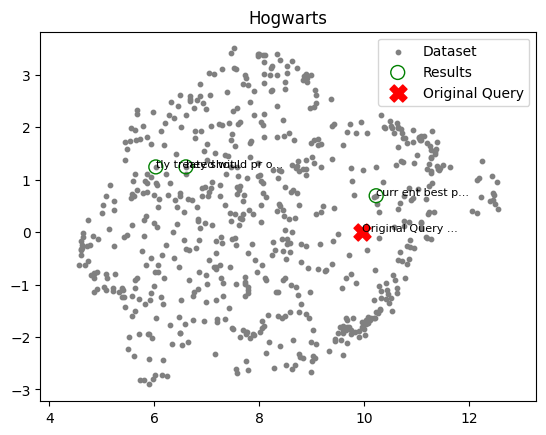

In [ ]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system

In [ ]:
from langchain.prompts import PromptTemplate

# Define a prompt template to inject retrieved context
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""Answer the following question based on the provided context. If the context doesn't contain relevant information, say 'I don't have enough information to answer that.'

Context: {context}

Question: {question}

Answer: """
)

# Simple QA function combining retrieval (simulated response since no LLM is directly available)
def answer_question(query):
    # Retrieve relevant chunks
    retrieved_texts, _, _ = retrieve(query, k=3)
    context = "\n".join(retrieved_texts)
    
    # Simulate an answer based on context (no external LLM in your list)
    if any(word in context.lower() for word in query.lower().split()):
        answer = f"Based on the context, here’s what I can tell you about '{query}':\n{context[:500]}..."
    else:
        answer = "I don't have enough information to answer that."
    
    # Create the prompt with retrieved context and simulated answer
    prompt = prompt_template.format(context=context, question=query) + answer
    return prompt

# Test the QA system
query = "What are machine learning algorithms?"
answer = answer_question(query)
print(f"Query: {query}")
print(f"Answer: {answer}")

Query: What are machine learning algorithms?
Answer: Answer the following question based on the provided context. If the context doesn't contain relevant information, say 'I don't have enough information to answer that.'

Context: tly treated wit h either a SABA alone or wit h regular ICS plus SABA as needed. The new r ecommendations represent a significant change in practice. The use of combination inhalers is mor e expensiv e than SABA alone, but cheaper t han r egular ICS plus SABA as needed. Ther efore, the cost impact will v ary depending on t he pr edominant f orm of tr eatment in each general practice. Ho wever, there should be futur e savings fr om a r eduction in se vere ast hma exacerbations
curr ent best practice. We have also made some minor changes – f or example f or clarity or wher e recommendations ha ve been amalgamat ed. These r ecommendations ar e mark ed [NICE 2017] , [NICE 2017 , amended NICE 2021] or [BTS/SIGN 2019] . March 2021: In recommendations 1 .14.1 and 1 .